In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


## Dataset

In [2]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('./datasets/MNIST_data', one_hot=True) # include one-hot labels

# # show a batch
# show_images(mnist.train.next_batch(16)[0])

In [3]:
tfrecords_filename = './datasets/celeba/celeba_train.tfrecords'

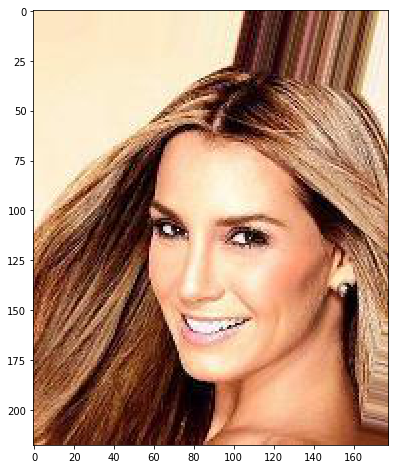

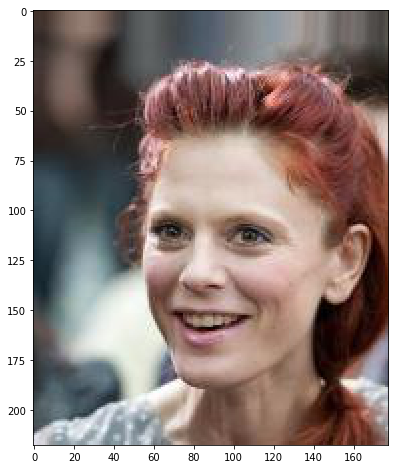

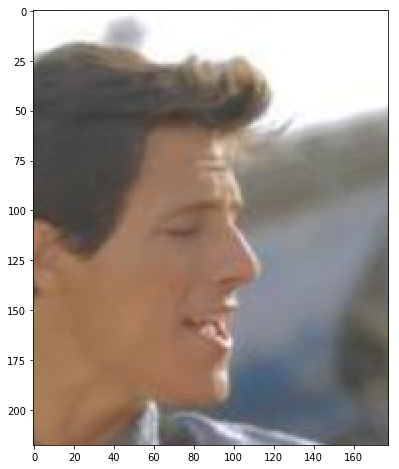

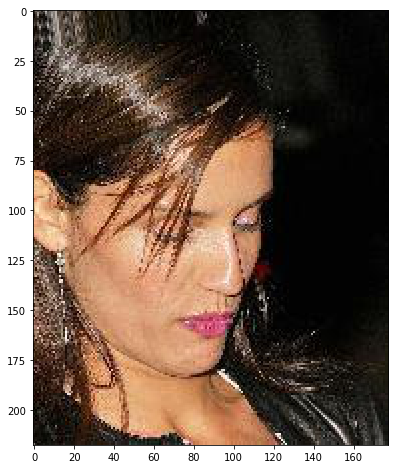

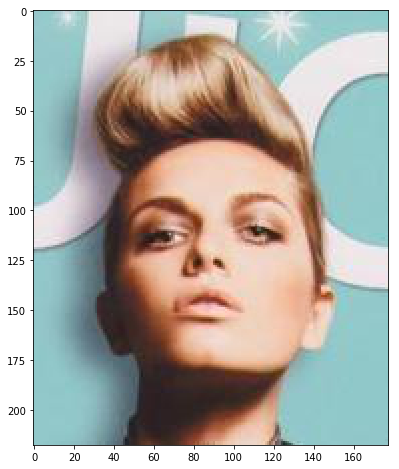

In [4]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    height = (example.features.feature['height']
                                  .int64_list
                                  .value[0])

    img_string = (example.features.feature['image_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
#     annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
#     reconstructed_annotation = annotation_1d.reshape((height, width))
    
#     reconstructed_images.append((reconstructed_img, reconstructed_annotation))
    reconstructed_images.append(reconstructed_img)

    
# Let's check if reconstructed images match
for reconstructed in reconstructed_images[:5]:
    plt.imshow(reconstructed)
    plt.show()

In [5]:
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384


def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'depth': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
#     annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
#     annotation_shape = tf.stack([height, width, 1])
    
    image = tf.reshape(image, image_shape)
#     annotation = tf.reshape(annotation, annotation_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
#     annotation_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
#     resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
    
    
#     images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
#                                                  batch_size=2,
#                                                  capacity=30,
#                                                  num_threads=2,
#                                                  min_after_dequeue=10)
    images = tf.train.shuffle_batch( [resized_image],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    annotations = None
    
    return images, annotations

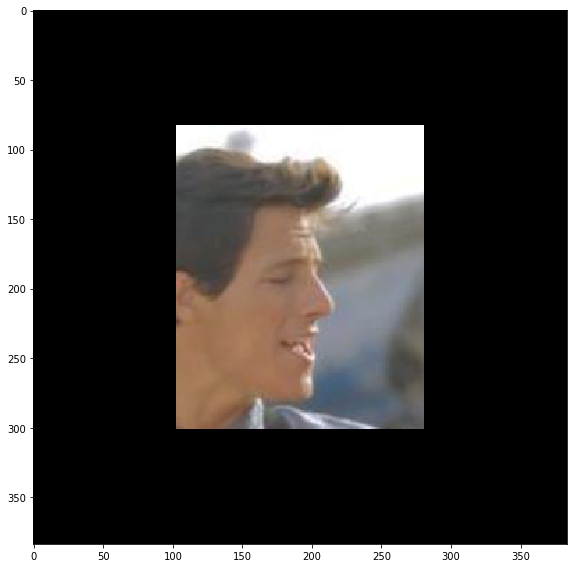

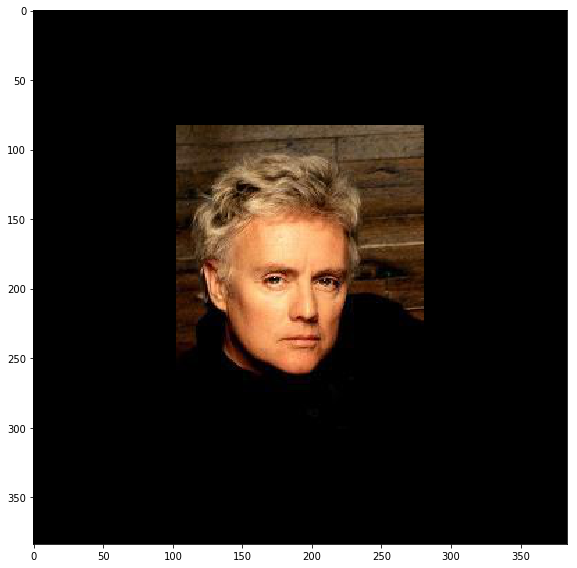

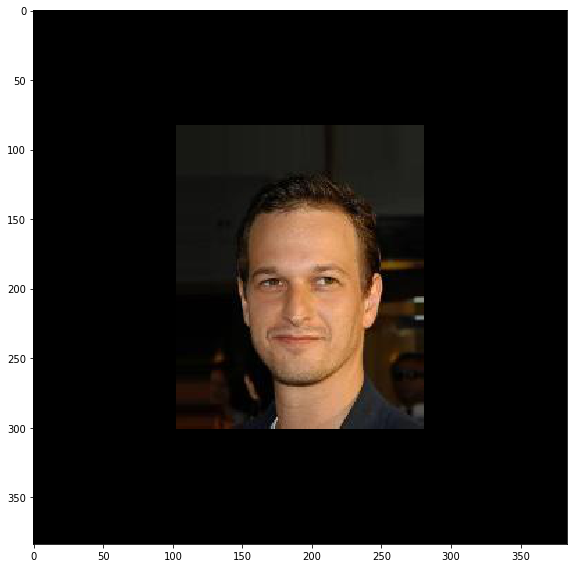

In [6]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img = sess.run(image)
        io.imshow(img[0, :, :, :])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)

## Helpers

In [7]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.

    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU

    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)


In [8]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.

    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate

    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim), minval=-1, maxval=1)


In [9]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.

    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)

    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """

    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

In [10]:
def discriminator(x, y):
    """Compute discriminator score for a batch of input images.

    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]

    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        inputs = tf.concat(values=[x, y], axis=1)

        fc1 = tf.layers.dense(inputs=inputs, units=256, activation=leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc2, units=1, activation=None)
        return logits

def generator(z, y):
    """Generate images from a random noise vector.

    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]

    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        inputs = tf.concat(values=[z, y], axis=1)

        fc1 = tf.layers.dense(inputs=inputs, units=1024, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=fc2, units=784, activation=tf.nn.tanh)
        return img

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.

    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image

    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_real_labels = tf.ones_like(logits_real)
    D_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=D_real_labels, logits=logits_real)
    D_false_labels = tf.zeros_like(logits_fake)
    D_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=D_false_labels, logits=logits_fake)
    D_loss = tf.reduce_mean(D_real_loss)+tf.reduce_mean(D_fake_loss)

    G_false_labels = tf.ones_like(logits_fake)
    G_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=G_false_labels, logits=logits_fake)
    G_loss = tf.reduce_mean(G_fake_loss)

    return D_loss, G_loss

In [12]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, 
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.

    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            num_samples = 16

            y_sample = np.zeros(shape=[batch_size, num_labels])
            y_sample[:, 5] = 1 # condition on class=5

            samples = sess.run(G_sample, feed_dict={y:y_sample})
            fig = show_images(samples[:num_samples])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y:minbatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch, y:minbatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')

    y_sample = np.zeros(shape=[batch_size, num_labels])
    y_sample[:, 5] = 1 # condition on class=5
    samples = sess.run(G_sample, feed_dict={y:y_sample})

    fig = show_images(samples[:16])
    plt.show()

## Build graph

In [13]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128

# number of labels
num_labels = mnist.train.labels.shape[1]

# our noise dimension
noise_dim = 96


# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, shape=[None, num_labels])

# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z, y)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x), y)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample, y)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

NameError: name 'mnist' is not defined

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)